# Challenge ENS : Real estate price prediction using tabular data and images

## 1. Introduction

### 1.1 Background

The project is a regression task that deals with real estate price estimation. Estimating housing real estate price is quite a common topic, with an important litterature on estimating prices based on usual data such as: location, surface, land, number of bedrooms, age of the building... The approaches are usually sufficient to estimate the price range but lack precision.

However, few have worked to see if adding photos of the asset would bring complementary information, enabling a more precise price estimation. The objective is thus to work on modelling French housing real estate prices based on usual hierarchical tabular data and, a few photos (between 1 and 6) for each asset and see if it allows better performance than a model trained without the photos.


### 1.2 Benchmark and evaluation metric

The ENS benchmark consists in an XGBoost regression model taking as input the tabular features from the df_train.csv file alongside a simple embedding of the corresponding listing images.

The tabular features were preprocessed as follows:

* imputing missing categorical features with an 'Unknown' modality
* imputing missing numerical and binary feature with the median value
* simple label encoding of the categorical features


The images were embedded by concatenating the following values:

* average red, green and blue values accross all pixels of the image (dominant color extraction),
* counts, quantiles and mean value of pixel values of a grayscale version of the image,
* counts, quantiles and mean value of the pixel values of the image obtained after applying a sobel edge detection filter on the grayscale version of the images.


For listings with more than one photo, we considered the average of the image vector embeddings described above.

The model was fine tuned with using a randomize parameter search grid and 5 fold cross-validation.


### 1.3 Code requirements

This notebook is running on my local machine :
* AMD Ryzen 5 3600 6/12 CPU
* 32 GB RAM
* Nvidia RTX 3080 with 10 GB of VRAM

software :
* Python 3.9
* Visual Studio Code
* Windows 10



## 2. Data

In [1]:
# Imports
import pandas as pd
from skimage import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Styles
sns.set_style("whitegrid")

### 2.1 Data frames

In [3]:
# Load training data
x_train_raw = pd.read_csv("data/X_train.csv")
y_train_raw = pd.read_csv("data/y_train.csv")

x_submission = pd.read_csv("data/X_test.csv")

In [4]:
# Merge x and y train data into a single dataframe
df_train = pd.merge(x_train_raw, y_train_raw, how="outer", on="id_annonce")

In [5]:
# Print data shape
print('df_train shape', df_train.shape)

# Show first entries
df_train.head(3)

df_train shape (37368, 28)


,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0


x_train.csv contains 27 explanatory variables described on the following table :

Name 						|	Type	|	Description																					|	Compulsory field on web platform|
|:-------------------------:|:---------:|:---------------------------------------------------------------------------------------------:|:---:|
id_annonce 					|	str		| 	Unique listing identification code															|True|
property_type 				|	str		|	Property type (house, apartment...)															|True|
approximate_latitude 		|	float	|	Latitude of the property with a small random Gaussian added for the sake of anonymization 	|False|
approximate_longitude 		|	float	|	Longitude of the property with a small random Gaussian added for the sake of anonymization 	|False|
city 						|	str		|	City in which the property is located														|True|
postal_code 				|	int 	|	Postal code of the property_type															|True|
size 						|	float	|	Living area of the property																	|False|
floor 						|	float	|	Floor at which the property is located														|False|
land_size 					|	float	|	Size of the land that comes with the property												|False|
energy_performance_value 	|	float	|	Energy performance value in kWh/m²/year														|False|
energy_performance_category |	char	|	Energy performance category as defined by the French DPE regulation							|False|
ghg_value 					|	float	|	Greenhouse gas emission performance value in kg eqCO2/m²									|False|
ghg_category 				|	char	|	Greenhouse gas emission performance category as defined by the French DPE regulation		|False|
exposition 					|	str		|	Direction the property is facing															|False|
nb_rooms 					|	int		|	Number of rooms in the property																|False|
nb_bedrooms 				|	int		|	Number of bedrooms in the property															|False|
nb_bathrooms 				|	int		|	Number of bathrooms in the property															|False|
nb_parking_places 			|	int		|	Number of parking places coming with the property 											|False|
nb_boxes 					|	int		|	Number of boxes coming with the property													|False|
nb_photos 					|	int		|	Number of photos posted on the listing 														|False|
has_a_balcony 				|	binary	|	Indicator whether there is a balcony in the property (1 if true, 0 if false)				|False|
nb_terraces 				|	binary	|	Number of terraces in the property															|False|
has_a_cellar 				|	binary	|	Indicator whether there is a cellar in the property (1 if true, 0 if false)					|False|
has_a_garage 				|	binary	|	Indicator whether there is a garage in the property (1 if true, 0 if false)					|False|
has_air_conditioning 		|	binary	|	Indicator whether there is air conditioning in the property (1 if true, 0 if false)			|False|
last_floor 					|	binary	|	Indicator whether the property is located on the top floor (1 if true, 0 if false)			|False|
upper_floors 				|	binary	|	Indicator whether the property is located in the upper floors (1 if true, 0 if false)		|False|
price 						|	float	| 	Price at which the property is listed														|True|

### 2.2 Images

Alongisde this tabular data, we have a compressed folder containing 1 to 6 photos per listing. For each listing, the corresponding photos are located in the folder named "ann_XXX" where XXX corresponds to the listing id_annonce. Images are of very poor resolution, under 200x200 pixels.

* Exemple for listing 15372691

In [6]:
# Explanatory variables
example_listing = 35956999
df_train.loc[df_train['id_annonce'] == example_listing]

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
16396,35956999,maison,49.465796,5.211589,mouzay,55700,78.0,NaN,217.0,NaN,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56000.0


In [7]:
# Images
def display_listing_images(id, folder_type="train"):
    """Open the images associated in the listing"""

    parent_folder = "data/reduced_images"

    # Find the files
    folder_name = os.path.join(parent_folder, folder_type, f"ann_{id}")    
    files = os.listdir(folder_name)

    # Display the files
    for file in files:
        if file.endswith(".jpg"):
            image = io.imread(os.path.join(folder_name, file))
            io.imshow(image)
            plt.show()


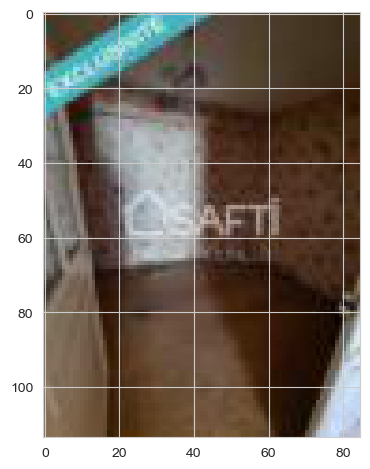

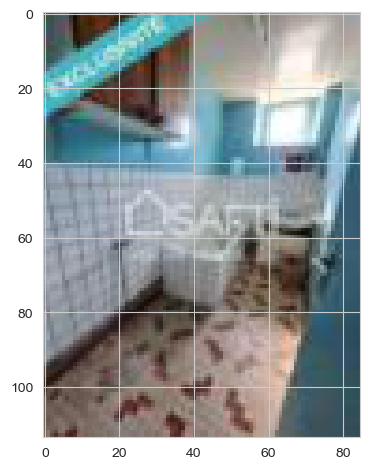

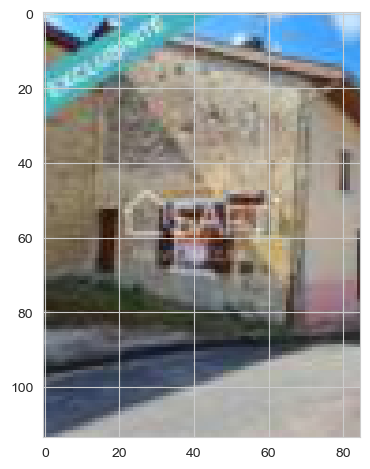

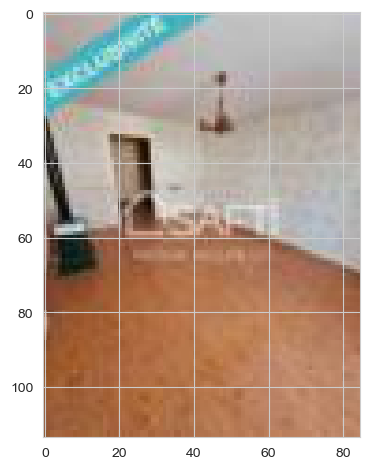

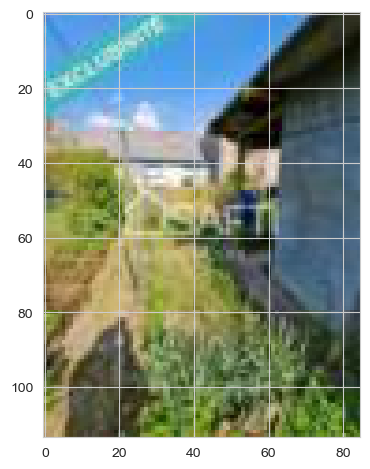

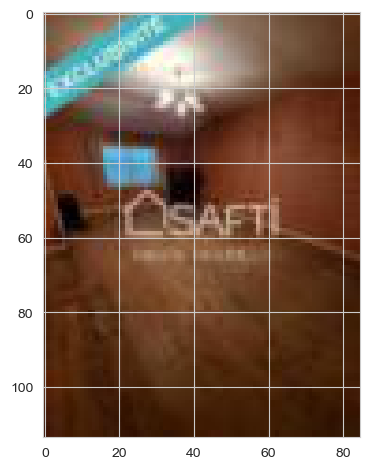

In [8]:
# Example display
display_listing_images(example_listing, "train")

## 3. Data Preprocessing and Feature Engineering

### 3.1. Data Preprocessing

We decide to replace the *Nan* by a label *Unknown* and a new variable to indicate if the variable have been imputed.

* id_annonce : unchanged
* property_type : *regroup* property_types into less categories
* approximate_latitude : **remove**
* approximate_longitude : **remove**
* city : **remove**
* postal_code : **remove**
* **NEW** : departement_attractive : binary 1/0 if the listing is in a 'hot' zipcode 
* size : unchanged
* floor : *replace* None by 'Unknown' label
* land_size : unchanged
* energy_performance_value : **remove**
* energy_performance_category : *replace* None by 'Unknown' label
* ghg_value : **remove**
* ghg_category : *replace* None by 'Unknown' label
* exposition : *replace* None by 'Unknown' label
* nb_rooms : *replace* None by median value for his property_type
* nb_bedrooms : *replace* None by median value for his property_type
* nb_bathrooms : **remove** because most values are at 1 or None. However, most houses have 2 bathrooms so the data is clearly incorrect.
* nb_parking_places : *changed* to has_parking
* nb_boxes : unchanged
* nb_photos : unchanged
* has_a_balcony : unchanged
* nb_terraces : unchanged
* has_a_cellar : unchanged
* has_a_garage : unchanged
* has_air_conditioning : unchanged
* last_floor : unchanged
* upper_floors : unchanged

In [9]:
# Helper functions

def get_frequency(col) -> pd.DataFrame:
    """
    Takes a DataFrame column as input and returns a DataFrame with the number of occurrences, frequency, 
    and relative frequency of each unique value in the column.
    """
    value_counts = col.value_counts()
    total_counts = value_counts.sum()
    freq = 100*value_counts / total_counts
    cum_freq = np.cumsum(freq)

    df_result = pd.DataFrame({
        'count': value_counts,
        'freq': freq,
        'cum_freq': cum_freq
        })
    
    return df_result


# Remove listings function

def remove_listings(id_list: list):
    """Remove listings from df_train, and images folder"""

    remove_count = 0
    not_found_count = 0

    df_train_filtered = df_train[~df_train['id_annonce'].isin(id_list)]

    for id in id_list:
        old_folder_name = f"data/reduced_images/train/ann_{id}"
        new_folder_name = f"data/reduced_images/train/dep_ann_{id}"

        try:
            os.rename(old_folder_name, new_folder_name)
            #print(f"Folder {old_folder_name} renamed to {new_folder_name}")
            remove_count += 1   
        except FileNotFoundError:
            #print(f"Folder {old_folder_name} does not exist")
            not_found_count += 1

    print(f"Number of renamed folders: {remove_count}")
    print(f"Number of not found folders: {not_found_count}")

    return df_train_filtered


# Reset folder names

def reset_folder_name():
    """ Reset the annonces folder names to ann_XXX"""

    rename_count = 0

    folder_path = "data/reduced_images/train"

    for folder_name in os.listdir(folder_path):
        folder_path_full = os.path.join(folder_path, folder_name)

        # Check if folder_name starts with "dep_"
        if folder_name.startswith("dep_"):
            
            new_folder_name = folder_name[4:]    # Remove the dep_ prefix

            os.rename(folder_path_full, os.path.join(folder_path, new_folder_name)) # Rename the folder
            rename_count += 1

    print(f"Number of resetted folders: {rename_count}")


In [10]:
# Reset folder names to remove the "dep"
reset_folder_name()

Number of resetted folders: 2875


#### 3.1.1. Consolidation inside variables

Property_type

In [11]:
print(get_frequency(df_train['property_type']))

                   count       freq    cum_freq
appartement        15733  42.102869   42.102869
maison             15675  41.947656   84.050525
divers              2137   5.718797   89.769321
terrain             1534   4.105117   93.874438
villa                781   2.090024   95.964462
propriété            408   1.091843   97.056305
terrain à bâtir      298   0.797474   97.853779
duplex               220   0.588739   98.442518
viager               177   0.473667   98.916185
ferme                130   0.347891   99.264076
parking               96   0.256904   99.520981
loft                  54   0.144509   99.665489
chalet                48   0.128452   99.793941
château               21   0.056198   99.850139
moulin                17   0.045493   99.895633
manoir                15   0.040141   99.935774
péniche                8   0.021409   99.957183
hôtel particulier      6   0.016057   99.973239
chambre                4   0.010704   99.983943
gîte                   3   0.008028   99

* "appartment" represents 42% of the listings.
* "duplex", "loft" are types of appartement.
* "viager" is a reverse mortgage, not a type of property. We group it with "divers".
* "terrain" (4.10%), "terrain à bâtir" (0.79%) can be grouped together.
* "hôtel", "Hôtel particulier", "atelier", "gite", "chambre", "péniche", "moulin" are extremely rare properties, they are removed.
* "parking" and "terrain" are outside the scope of this projetct, it's removed.
* "villa", "chalet", "château", "moulin", "manoir" can be combined in a "Luxe" category.

In [12]:
# Remove listings of rares types
id_to_delete = df_train.loc[df_train["property_type"].isin(["hôtel", "atelier", "gîte", "chambre", "hôtel particulier", "péniche", "parking", "moulin", "terrain", "terrain à bâtir"]),
                   "id_annonce"]

df_train = remove_listings(id_to_delete)

Number of renamed folders: 1969
Number of not found folders: 0


In [13]:
# Regroup common categories
mapping = [
    ('appartement', 'appartement'),
    ('maison', 'maison'),
    ('propriété', 'luxe'),
    ('divers', 'divers'),
    ('duplex', 'appartement'),
    ('villa', 'luxe'),
    ('viager', 'divers'),
    ('ferme', 'ferme'),
    ('loft', 'appartement'),
    ('manoir', 'luxe'),
    ('chalet', 'luxe'),
    ('château', 'luxe')    
]

for k,v in mapping:
    df_train['property_type'] = df_train["property_type"].str.replace(k,v)

# If the size of a listing is greater than the size of the land, we switch the two variables
mask = (df_train['size'] > df_train['land_size']) & (df_train['property_type'] != 'appt')
df_train.loc[mask, ['size', 'land_size']] = df_train.loc[mask, ['land_size', 'size']].values

# If land_size == 5, we assign size to the land_size. It appears to be a data error
df_train.loc[(df_train["land_size"] == 5), "land_size"] = df_train.loc[(df_train["land_size"] == 5), "size"] 

In [14]:

# For size, we drop the unknown & remove all size, landsize > 1 000 000 and size > 10000
# We remove all listings under 9 square meters, the legal minimum for a dwelling unit in France.
mask = (df_train["size"].isna()) | (df_train["size"] < 9) | (df_train["land_size"] > 1000000)  | (df_train["size"] > 10000)
id_to_delete = df_train.loc[mask, "id_annonce"].tolist()
df_train = remove_listings(id_to_delete)

# Appartments have no land size
df_train.loc[df_train["property_type"] == "appartement", "land_size"] = 0


Number of renamed folders: 906
Number of not found folders: 0


appartement    15581
maison         15491
divers          2050
luxe            1243
ferme            128
Name: property_type, dtype: int64

In [15]:
# Size over 500 sq meters are "luxe"
mask = (df_train["size"] > 500) | ((df_train["property_type"] != "appartement") & (df_train["land_size"] > 5*df_train["size"]))
df_train.loc[mask, "property_type"] = "luxe"

Exposition

In [17]:
# Exposition
mapping = [
    ('Sud', 'Sud'),
    ('Sud-Ouest', 'Sud'),
    ('Sud-Est', 'Sud'),
    ('Est-Ouest', 'Est-Ouest'),
    ('Ouest', 'Ouest'),
    ('Est', 'Est'),
    ('Sud-Nord', 'Nord-Sud'),
    ('Nord-Ouest', 'Nord'),
    ('Nord', 'Nord'),
    ('Nord-Est', 'Nord'),
    ('Ouest-Est', 'Est-Ouest'),
    ('Nord-Sud', 'Nord-Sud') 
]

for k,v in mapping:
    df_train['exposition'] = df_train["exposition"].str.replace(k,v)

df_train['exposition'] = df_train['exposition'].fillna('Unknown')

Unknown      25769
Sud           5382
Est-Ouest      819
Ouest          772
Nord           717
Est            669
Nord-Sud       365
Name: exposition, dtype: int64

#### 3.1.2. Creation of new variables

Zip codes of attractive departements are coded. Attractive departments are : Paris, coastal areas, Strasbourg, border to Switzerland. It's based on real estate price on the area.

In [18]:
# Create new variable : dept_attractive
dep_attract = ['59','67','68','69','74','06','83','2A','2B','13','84','34','66','31','64','40','33','17','44','56','75','77','78','91','92','93','94','95']
df_train["dept_attractive"] = df_train["postal_code"].astype(str).str[:2].isin(dep_attract).astype("category")

True     19747
False    14746
Name: dept_attractive, dtype: int64

In [19]:
# Integer to Categorical
df_train["has_parking"] = (np.where((df_train["nb_parking_places"] > 0) | (df_train["nb_boxes"] > 0) | (df_train["has_a_garage"] == 1), 1, 0))
df_train["has_parking"] = df_train["has_parking"].astype('category')

#### 3.1.3 Missing variables

##### 3.1.3.1. In categorical variables

We replace the missing data by a new label 'Unknown'

In [20]:
# energy_performance_category
df_train['ghg_category'] = df_train['ghg_category'].fillna('Unknown')
df_train['ghg_category'] = pd.Categorical(df_train['ghg_category'], categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown'], ordered=True)

# ghg_category
df_train['energy_performance_category'] = df_train['energy_performance_category'].fillna('Unknown')
df_train['energy_performance_category'] = pd.Categorical(df_train['energy_performance_category'], categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Unknown'], ordered=True)

Unknown    16302
B           4469
C           3349
D           3189
E           2946
A           2510
F           1237
G            491
Name: ghg_category, dtype: int64
Unknown    15785
D           6892
C           4031
E           3735
B           2110
F           1032
A            607
G            301
Name: energy_performance_category, dtype: int64


In [21]:
# Replace by the median value for its property_type
df_train["land_size"].fillna(df_train.groupby('property_type')['nb_rooms'].transform('median'), inplace=True)

##### 3.1.3.2 In numerical variables

We impute the missing numerical value by median calculated for each property size.

In [22]:
# Replace floor by its median value
df_train['floor'].fillna(df_train["floor"].median(), inplace=True)

# Replace by the median value for its property_type
df_train["nb_rooms"].fillna(df_train.groupby('property_type')['nb_rooms'].transform('median'), inplace=True)
df_train["nb_bedrooms"].fillna(df_train.groupby('property_type')['nb_bedrooms'].transform('median'), inplace=True)


Size, land size ratio


Land_ratio est calculé par le log du ratio land_size / size. 
Un appartement ayant un land_size de 0, le ratio vaut 0.
Plus le terrain est grand, plus le ratio est grand.

In [23]:
# Size / Land size ratio
df_train["land_ratio"] = np.where(
    (~np.isnan(df_train["size"])) & (~np.isnan(df_train["land_size"])),
    df_train["land_size"] / df_train["size"],
    0
)
df_train.loc[df_train['property_type'] == 'appartement', 'land_ratio'] = 0
df_train["land_ratio"] = np.log(1 + df_train["land_ratio"])


Integer to Categorical

In [24]:
for col in ['has_a_balcony', 'nb_terraces', 'has_a_cellar', 'has_air_conditioning', 'last_floor', 'upper_floors', 'has_parking']:
    df_train[col] = df_train[col].astype('category')


#### 3.1.4. Dropping columns

We drop column with now irrelevant or duplicate information.

In [25]:
# Dropping columns
cols_to_remove = [
    'approximate_latitude',
    'approximate_longitude',
    'city',
    'postal_code',
    'energy_performance_value',
    'ghg_value',
    'nb_parking_places',
    'nb_boxes',
    'has_a_garage',
    'nb_bathrooms'
]

df_train = df_train.drop(columns=cols_to_remove)

In [26]:
# Missing values

# Calculate the percentage of missing values for each column
missing_percentages = (df_train.isna().mean() * 100).round(2)

# Print the result
print(missing_percentages.sort_values(ascending=False))

id_annonce                     0.0
has_a_balcony                  0.0
has_parking                    0.0
dept_attractive                0.0
price                          0.0
upper_floors                   0.0
last_floor                     0.0
has_air_conditioning           0.0
has_a_cellar                   0.0
nb_terraces                    0.0
nb_photos                      0.0
property_type                  0.0
nb_bedrooms                    0.0
nb_rooms                       0.0
exposition                     0.0
ghg_category                   0.0
energy_performance_category    0.0
land_size                      0.0
floor                          0.0
size                           0.0
land_ratio                     0.0
dtype: float64
